In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#houses = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Minería de dato/Data/dataset.csv')
houses = pd.read_csv('/content/dataset.csv')
houses.head()

,FIPS,CountyName,StateName,NumberOfSchools,NumberOfHospitals,AverageHospitalRating,UnemploymentRate,crime_rate_per_100000,AverageHousePrice,ZHVIPerSqft_AllHomes,MedianRentalPrice_AllHomes
0,1001,Autauga,Alabama,15,1,4.00,3.6,251.601926,114483.67,72.56,1255.21
1,1003,Baldwin,Alabama,47,4,3.00,3.6,228.086325,164861.69,90.39,1165.94
2,1069,Houston,Alabama,31,5,3.50,4.1,401.281012,114941.00,72.94,975.63
3,1073,Jefferson,Alabama,226,14,2.75,3.7,798.357491,99759.77,68.25,855.86
4,1081,Lee,Alabama,37,1,4.00,3.6,246.466975,148163.22,74.79,1143.89


In [ ]:
houses.isnull().sum()

FIPS                          0
CountyName                    0
StateName                     0
NumberOfSchools               0
NumberOfHospitals             0
AverageHospitalRating         0
UnemploymentRate              0
crime_rate_per_100000         0
AverageHousePrice             0
ZHVIPerSqft_AllHomes          0
MedianRentalPrice_AllHomes    0
dtype: int64

In [ ]:
houses.shape

(535, 11)

In [5]:
var_map = {'NumberOfSchools':'Number of Schools', 'NumberOfHospitals':'Number of Hospitals', 'AverageHospitalRating':'Average Hospital Rating',
           'UnemploymentRate':'Unemployment Rate', 'crime_rate_per_100000':'Crime Rate (per 100000)', 'AverageHousePrice': 'House Price',
           'ZHVIPerSqft_AllHomes':'Value Per Square Feet', 'MedianRentalPrice_AllHomes':'Average Rental Price'}

In [6]:
houses_train, houses_test = train_test_split(houses, test_size = 0.2)

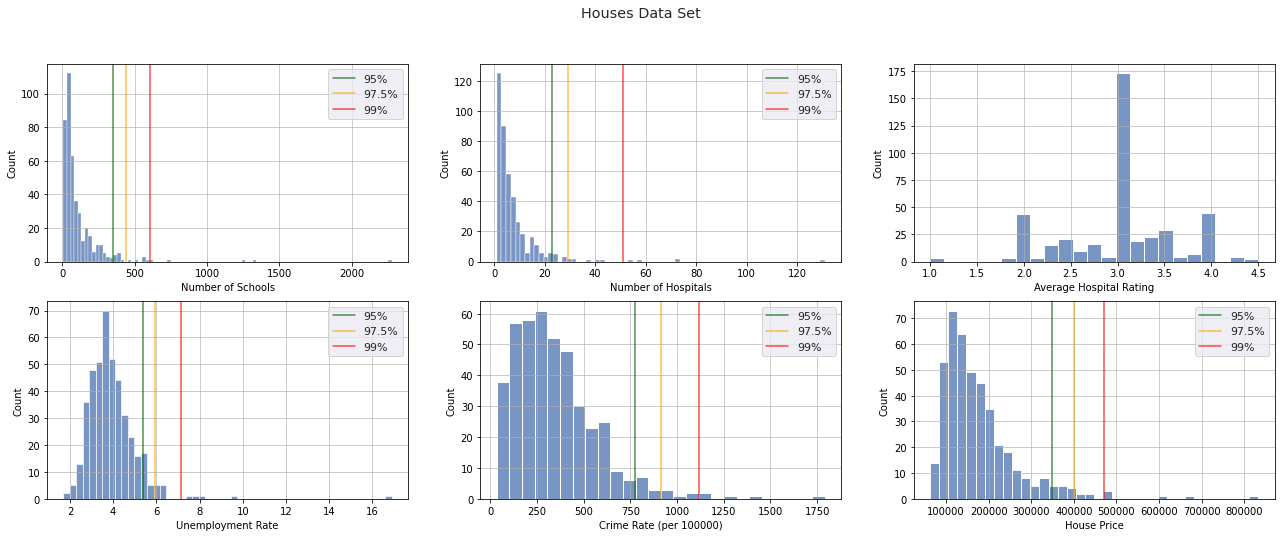

In [7]:
vars2plot = ['NumberOfSchools', 'NumberOfHospitals', 'AverageHospitalRating', 'UnemploymentRate', 'crime_rate_per_100000', 'AverageHousePrice']
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (22, 8))

var_number = 0
for i in range(2):
  for j in range(3):
    sns.set_theme()
    sns.histplot(data = houses_train, x = vars2plot[var_number], ax = axes[i,j])
    if vars2plot[var_number] != 'AverageHospitalRating':
      axes[i,j].axvline(houses_train[vars2plot[var_number]].quantile(0.95), color = 'darkgreen', alpha = 0.7, label = '95%')
      axes[i,j].axvline(houses_train[vars2plot[var_number]].quantile(0.975), color = 'orange', alpha = 0.7, label = '97.5%')
      axes[i,j].axvline(houses_train[vars2plot[var_number]].quantile(0.99), color = 'red', alpha = 0.7, label = '99%')
      axes[i,j].legend()
    axes[i,j].grid(alpha = 0.8)
    axes[i,j].set_xlabel(var_map[vars2plot[var_number]])
    var_number += 1

fig.suptitle('Houses Data Set')
plt.show()

In [8]:
houses_wout_outliers = houses_train.copy()
probability = 0.975

for var in vars2plot:
  if var != 'AverageHospitalRating':
    var_quantile = houses_train[var].quantile(probability)
    houses_wout_outliers = houses_wout_outliers[houses_wout_outliers[var] <= var_quantile]

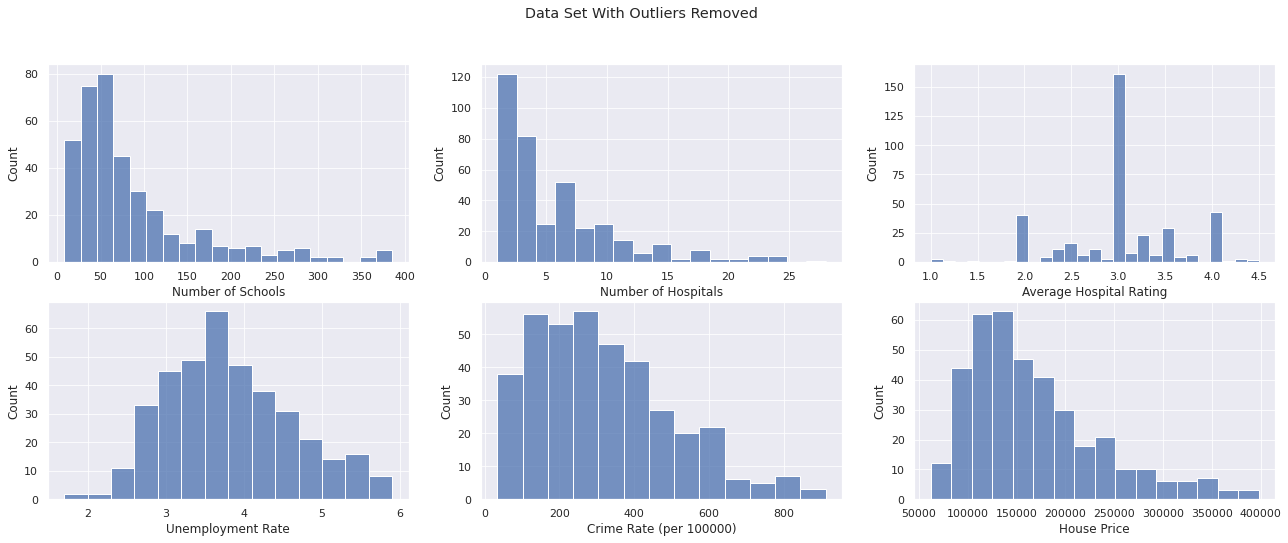

In [9]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (22, 8))

var_number = 0
for i in range(2):
  for j in range(3):
    sns.set_theme()
    sns.histplot(data = houses_wout_outliers, x = vars2plot[var_number], ax = axes[i,j])
    axes[i,j].grid(alpha = 0.8)
    axes[i,j].set_xlabel(var_map[vars2plot[var_number]])
    var_number += 1

fig.suptitle('Data Set With Outliers Removed')
plt.show()

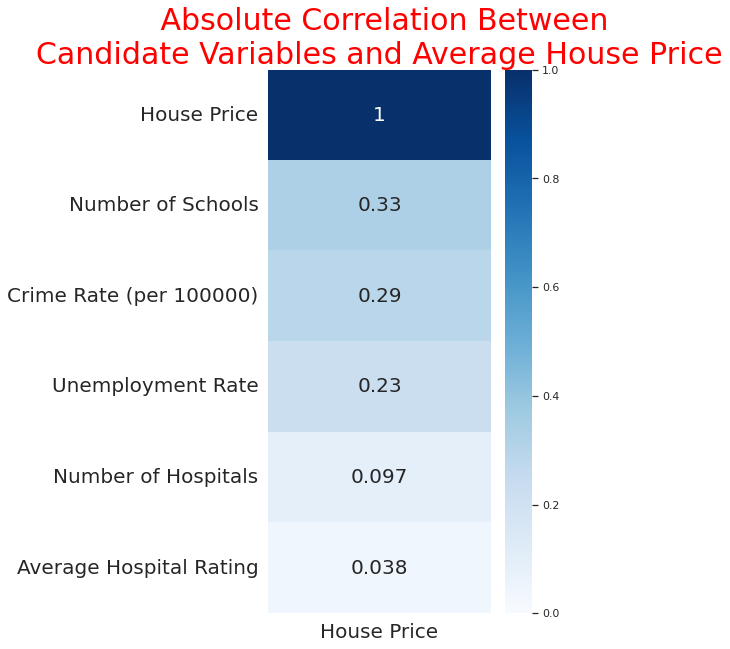

In [10]:
plt.figure(figsize = (5, 10))

temp_df = pd.DataFrame(np.abs(houses_wout_outliers[vars2plot].corr()['AverageHousePrice']))
temp_df.rename(index = var_map, columns = var_map, inplace = True)
temp_df = temp_df.sort_values('House Price', ascending = False)

sns.heatmap(temp_df, cmap = 'Blues', annot = True, annot_kws={"fontsize":20}, vmin = 0, vmax = 1)
plt.title(' Absolute Correlation Between\nCandidate Variables and Average House Price', fontsize = 30, color = 'red')
plt.tick_params(labelsize=20)
plt.show()

Esta es la prueba que indica que el estado aporta información interesante respecto de los precios de las casas. Aqui conviene utilizar el FIPS en lugar del estado

In [13]:
kruskal_test = kruskal(*[houses_wout_outliers['AverageHousePrice'][houses_wout_outliers['StateName'] == c] for c in houses_wout_outliers['StateName'].unique()])
print(kruskal_test)

KruskalResult(statistic=174.23333770536942, pvalue=3.208845222499871e-16)


In [14]:
candidate_vars = ['FIPS', 'NumberOfSchools', 'NumberOfHospitals', 'UnemploymentRate', 'crime_rate_per_100000', 'AverageHousePrice']
objective_var = 'AverageHousePrice'
predictor_vars = [var for var in candidate_vars if var != 'AverageHousePrice']

# Transformacion del dataset

In [15]:
houses_wout_outliers_preproc = houses_wout_outliers.copy()
for var in candidate_vars:
  if var != 'FIPS':
    houses_wout_outliers_preproc[var] = houses_wout_outliers_preproc[var].apply(lambda x: np.log1p(x))
    houses_test[var] = houses_test[var].apply(lambda x: np.log1p(x))

In [16]:
houses_wout_outliers_preproc.head()

,FIPS,CountyName,StateName,NumberOfSchools,NumberOfHospitals,AverageHospitalRating,UnemploymentRate,crime_rate_per_100000,AverageHousePrice,ZHVIPerSqft_AllHomes,MedianRentalPrice_AllHomes
167,17143,Peoria,Illinois,4.356709,1.609438,3.20,1.840550,6.405131,11.442975,74.14,845.21
358,37135,Orange,North Carolina,3.583519,0.693147,2.99,1.458615,5.028876,12.289372,122.49,1362.22
413,42049,Erie,Pennsylvania,4.317488,2.302585,3.40,1.757858,5.517268,11.496553,71.42,920.00
102,12085,Martin,Florida,3.637586,1.791759,2.99,1.504077,5.573889,12.134078,114.58,1566.13
267,27163,Washington,Minnesota,4.553877,1.098612,4.00,1.252763,4.230043,12.281526,111.75,1425.69


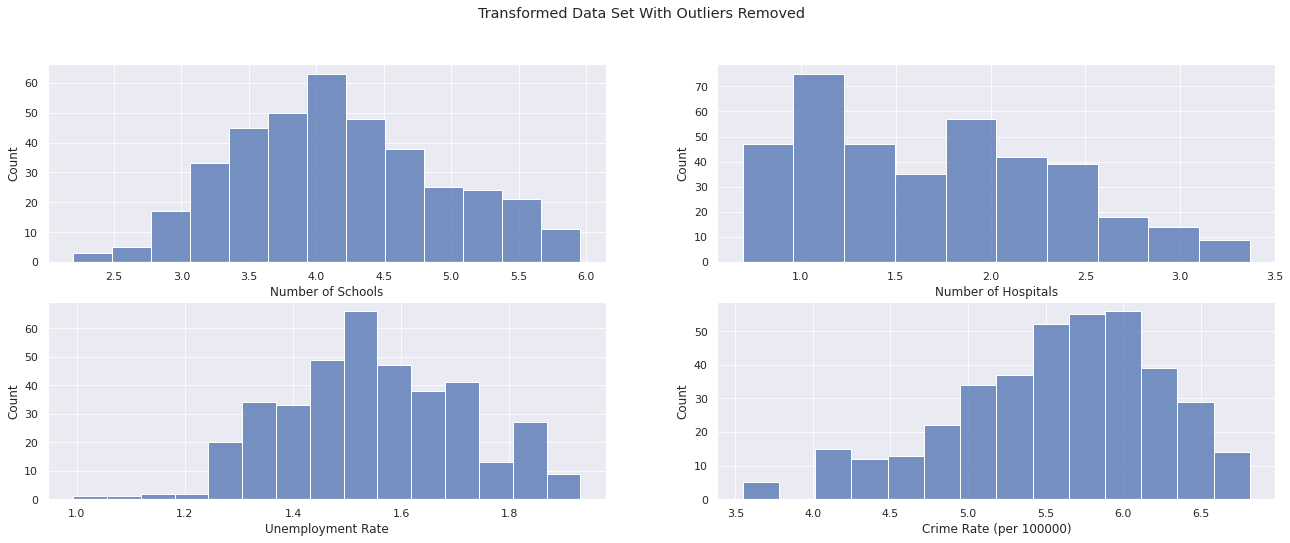

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (22, 8))

var_number = 0
for i in range(2):
  for j in range(2):
    sns.set_theme()
    sns.histplot(data = houses_wout_outliers_preproc, x = predictor_vars[var_number + 1], ax = axes[i,j])
    axes[i,j].grid(alpha = 0.8)
    axes[i,j].set_xlabel(var_map[predictor_vars[var_number + 1]])
    var_number += 1

fig.suptitle('Transformed Data Set With Outliers Removed')
plt.show()

# Regresión Lineal

In [21]:
X_train = houses_wout_outliers_preproc[predictor_vars]
Y_train = houses_wout_outliers_preproc[objective_var]
X_train = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:      AverageHousePrice   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     36.45
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           1.94e-30
Time:                        17:40:08   Log-Likelihood:                -94.227
No. Observations:                 383   AIC:                             200.5
Df Residuals:                     377   BIC:                             224.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.78

In [22]:
X_test = houses_test[predictor_vars]
Y_test = houses_test[objective_var]
X_test = sm.add_constant(X_test)
Y_pred = model.predict(X_test)

In [23]:
print("mse of the model : ", mean_squared_error(Y_test, Y_pred))

mse of the model :  0.15844386069335406


# Arbol de decisión

In [24]:
X_train = houses_wout_outliers_preproc[predictor_vars]
Y_train = houses_wout_outliers_preproc[objective_var]
X_test = houses_test[predictor_vars]
Y_test = houses_test[objective_var]
tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)

In [25]:
print("mse of the model : ", mean_squared_error(Y_test, Y_pred))

mse of the model :  0.18086783701518538


In [26]:
r2_score(Y_test, Y_pred)

0.12639127389384608